In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from qutip import *


In [12]:
pi = np.pi
N = 2

wc = 5.0 * 2 * pi
w1 = 3.0 * 2 * pi
w2 = 2.0 * 2 * pi

g1 = 0.01 * 2 * pi
g2 = 0.0125 * 2 * pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g2)

In [13]:

# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2
     

In [14]:

# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 
H.eigenenergies()
     

array([-15.70796327,  -3.14191991,   3.14127853,  15.70732189,
        15.70860465,  28.27464801,  34.55784644,  47.1238898 ])

In [15]:


# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

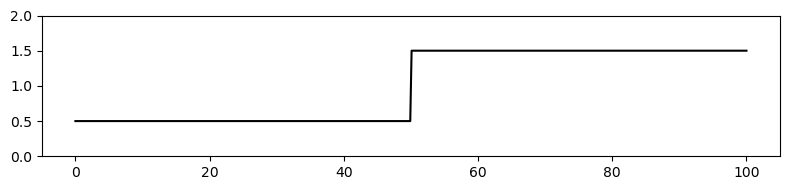

In [16]:

def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [17]:


def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

In [28]:
H_t[0]

[Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dia, isherm=True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]],
 <function __main__.wc_t(t, args=None)>]

In [29]:
H_t[1]

[Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[-0.5  0.   0.   0.   0.   0.   0.   0. ]
  [ 0.  -0.5  0.   0.   0.   0.   0.   0. ]
  [ 0.   0.   0.5  0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.5  0.   0.   0.   0. ]
  [ 0.   0.   0.   0.  -0.5  0.   0.   0. ]
  [ 0.   0.   0.   0.   0.  -0.5  0.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.5  0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.5]],
 <function __main__.w1_t(t, args=None)>]

In [30]:
H_t[2]

[Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[-0.5  0.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.5  0.   0.   0.   0.   0.   0. ]
  [ 0.   0.  -0.5  0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.5  0.   0.   0.   0. ]
  [ 0.   0.   0.   0.  -0.5  0.   0.   0. ]
  [ 0.   0.   0.   0.   0.   0.5  0.   0. ]
  [ 0.   0.   0.   0.   0.   0.  -0.5  0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.5]],
 <function __main__.w2_t(t, args=None)>]

In [33]:
print(H_t[3])

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.07853982 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.06283185 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.06283185
  0.07853982 0.        ]
 [0.         0.07853982 0.06283185 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.06283185 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.07853982 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [37]:

res = mesolve(H_t, psi0, tlist, [], [])

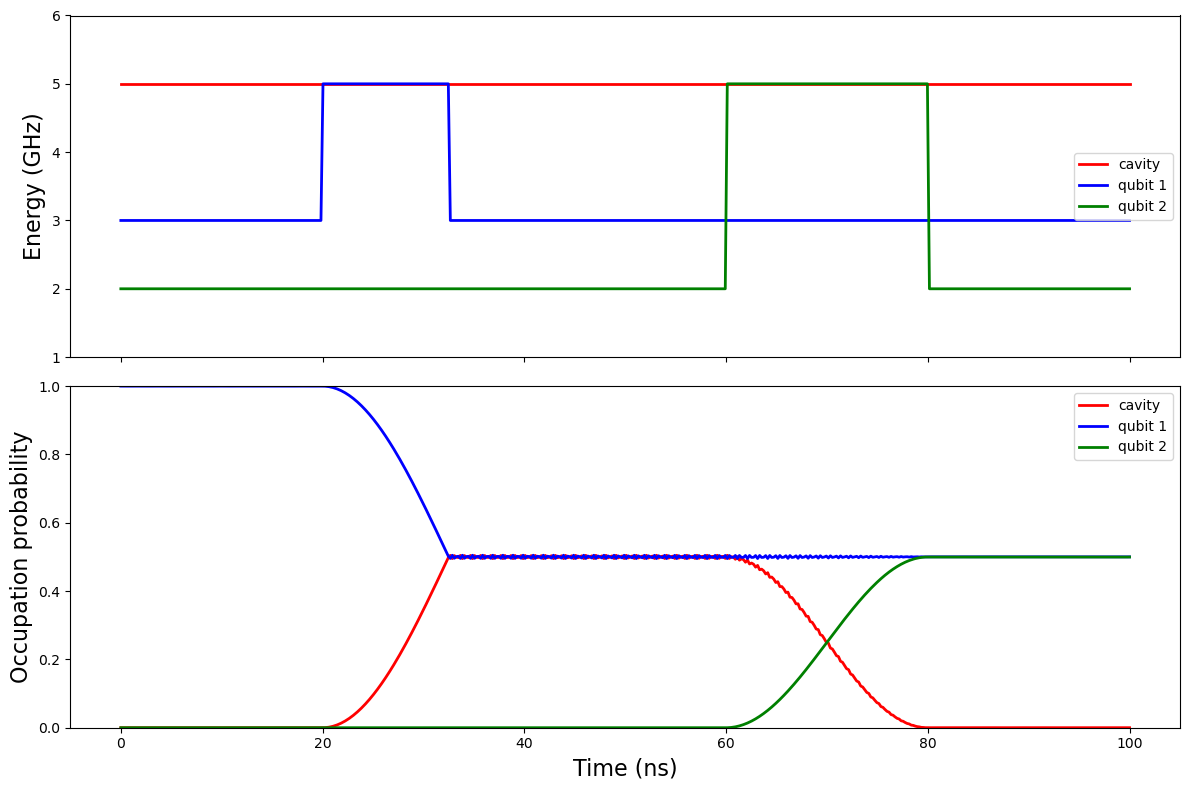

In [38]:
from numpy import array
from numpy import real

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [39]:

# extract the final state from the result of the simulation
rho_final = res.states[-1]

In [40]:

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits
     

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 6.16909641e-05+0.j         0.00000000e+00+0.j
   0.00000000e+00+0.j         0.00000000e+00+0.j       ]
 [ 0.00000000e+00+0.j         4.99792760e-01+0.j
  -4.99575076e-01+0.0198461j  0.00000000e+00+0.j       ]
 [ 0.00000000e+00+0.j        -4.99575076e-01-0.0198461j
   5.00145549e-01+0.j         0.00000000e+00+0.j       ]
 [ 0.00000000e+00+0.j         0.00000000e+00+0.j
   0.00000000e+00+0.j         0.00000000e+00+0.j       ]]

In [41]:
from qutip.core.gates import *
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

In [42]:


fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.019851409318636885)

In [43]:

concurrence(rho_qubits)

np.float64(0.999938241706284)